In [1]:
import os
import inspect
import csv as csv
import re
import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNetCV, ElasticNet
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.tree import _tree, DecisionTreeRegressor, plot_tree
from sklearn.feature_selection import mutual_info_regression, RFE, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import (
    log_loss,
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer,
    classification_report
)
from lightgbm import LGBMRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

import xgboost as xgb

from category_encoders import TargetEncoder



In [16]:
df = pd.read_csv('pca2.csv')
df.head()

,SERIALNO,SPORDER,WAGP,AGEP,COW,SCHL,SEX,WKHP,ESR,NAICSP,RAC1P,HISP,INDP,OCCP,SCIENGP,SCIENGRLP,RACE
0,2023000000009,1,3600,19,1,19,2,16,1,7220,8,2,8680,4055,3,3,0
1,2023000000028,1,800,23,1,19,1,15,1,7115,1,1,8564,2850,3,3,1
2,2023000000052,1,1800,23,1,20,1,15,1,7115,1,1,8564,2850,3,3,1
3,2023000000125,1,65000,28,1,19,1,40,6,4492,9,2,4796,4760,3,3,0
4,2023000000152,1,3000,20,1,19,2,20,6,61101,2,1,7870,4640,3,3,2


# Feature Engineering

In [ ]:

df['SCHL'] = df['SCHL'].astype(int)

# Define the education level mapping
edu_mapping = {
    15: 'High school',
    19: 'High school graduate',
    20: 'Associates',
    21: 'Bachelors',
    22: 'Masters',
    23: 'Professional degree beyond bachelors',
    24: 'Doctorate'
}

# Apply the mapping
df['SCHL'] = df['SCHL'].map(edu_mapping)

df['SCHL_Encoded'] = df['SCHL'].astype('category').cat.codes

print(df.head())


        SERIALNO  SPORDER   WAGP  AGEP  COW                  SCHL  SEX  WKHP  \
0  2023000000009        1   3600    19    1  High school graduate    2    16   
1  2023000000028        1    800    23    1  High school graduate    1    15   
2  2023000000052        1   1800    23    1            Associates    1    15   
3  2023000000125        1  65000    28    1  High school graduate    1    40   
4  2023000000152        1   3000    20    1  High school graduate    2    20   

   ESR  NAICSP  RAC1P  HISP  INDP  OCCP  SCIENGP  SCIENGRLP  RACE  \
0    1    7220      8     2  8680  4055        3          3     0   
1    1    7115      1     1  8564  2850        3          3     1   
2    1    7115      1     1  8564  2850        3          3     1   
3    6    4492      9     2  4796  4760        3          3     0   
4    6   61101      2     1  7870  4640        3          3     2   

   SCHL_Encoded  
0             4  
1             4  
2             0  
3             4  
4             

In [ ]:


df['COW'] = df['COW'].astype('category')


df['WKHP_Binned'] = pd.cut(df['WKHP'], bins=[0, 30, 45, np.inf], labels=['Part-Time', 'Full-Time', 'Overtime'])

df['INDP'] = df['INDP'].astype('category')

print(df.head())


        SERIALNO  SPORDER   WAGP  AGEP COW                  SCHL  SEX  WKHP  \
0  2023000000009        1   3600    19   1  High school graduate    2    16   
1  2023000000028        1    800    23   1  High school graduate    1    15   
2  2023000000052        1   1800    23   1            Associates    1    15   
3  2023000000125        1  65000    28   1  High school graduate    1    40   
4  2023000000152        1   3000    20   1  High school graduate    2    20   

   ESR  NAICSP  RAC1P  HISP  INDP  OCCP  SCIENGP  SCIENGRLP  RACE  \
0    1    7220      8     2  8680  4055        3          3     0   
1    1    7115      1     1  8564  2850        3          3     1   
2    1    7115      1     1  8564  2850        3          3     1   
3    6    4492      9     2  4796  4760        3          3     0   
4    6   61101      2     1  7870  4640        3          3     2   

   SCHL_Encoded WKHP_Binned  
0             4   Part-Time  
1             4   Part-Time  
2             0   Pa

In [19]:


def remove_top_5_percent(df, target_feature):
    """
    Removes the top 5% of values from the specified target feature in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    target_feature (str): The column name of the target feature.

    Returns:
    pd.DataFrame: A new DataFrame with the top 5% of values removed.
    """
    threshold = df[target_feature].quantile(0.95)  # Calculate 95th percentile
    return df[df[target_feature] <= threshold]  # Keep only values below the threshold
df_clean = df.copy()
df_clean = remove_top_5_percent(df, 'WAGP')
df_clean.head()

,SERIALNO,SPORDER,WAGP,AGEP,COW,SCHL,SEX,WKHP,ESR,NAICSP,RAC1P,HISP,INDP,OCCP,SCIENGP,SCIENGRLP,RACE,SCHL_Encoded,WKHP_Binned
0,2023000000009,1,3600,19,1,High school graduate,2,16,1,7220,8,2,8680,4055,3,3,0,4,Part-Time
1,2023000000028,1,800,23,1,High school graduate,1,15,1,7115,1,1,8564,2850,3,3,1,4,Part-Time
2,2023000000052,1,1800,23,1,Associates,1,15,1,7115,1,1,8564,2850,3,3,1,0,Part-Time
3,2023000000125,1,65000,28,1,High school graduate,1,40,6,4492,9,2,4796,4760,3,3,0,4,Full-Time
4,2023000000152,1,3000,20,1,High school graduate,2,20,6,61101,2,1,7870,4640,3,3,2,4,Part-Time


In [20]:
df_clean = pd.get_dummies(df_clean, columns=['COW', 'WKHP_Binned'], drop_first=True)
print(df_clean.columns)

Index(['SERIALNO', 'SPORDER', 'WAGP', 'AGEP', 'SCHL', 'SEX', 'WKHP', 'ESR',
       'NAICSP', 'RAC1P', 'HISP', 'INDP', 'OCCP', 'SCIENGP', 'SCIENGRLP',
       'RACE', 'SCHL_Encoded', 'COW_2', 'COW_3', 'COW_4', 'COW_5', 'COW_6',
       'COW_7', 'COW_8', 'WKHP_Binned_Full-Time', 'WKHP_Binned_Overtime'],
      dtype='object')


In [ ]:
encoder = TargetEncoder(cols=['INDP'])
df_clean['INDP_Encoded'] = encoder.fit_transform(df_clean['INDP'], df_clean['WAGP'])  


In [22]:
df_clean['WAGP_Log'] = np.log1p(df_clean['WAGP'])  # Log transform to normalize
df_clean.head()

,SERIALNO,SPORDER,WAGP,AGEP,SCHL,SEX,WKHP,ESR,NAICSP,RAC1P,...,COW_3,COW_4,COW_5,COW_6,COW_7,COW_8,WKHP_Binned_Full-Time,WKHP_Binned_Overtime,INDP_Encoded,WAGP_Log
0,2023000000009,1,3600,19,High school graduate,2,16,1,7220,8,...,0,0,0,0,0,0,0,0,26657.642359,8.188967
1,2023000000028,1,800,23,High school graduate,1,15,1,7115,1,...,0,0,0,0,0,0,0,0,53110.831826,6.685861
2,2023000000052,1,1800,23,Associates,1,15,1,7115,1,...,0,0,0,0,0,0,0,0,53110.831826,7.496097
3,2023000000125,1,65000,28,High school graduate,1,40,6,4492,9,...,0,0,0,0,0,0,1,0,66865.645412,11.082158
4,2023000000152,1,3000,20,High school graduate,2,20,6,61101,2,...,0,0,0,0,0,0,0,0,55722.197783,8.006701


# Feature Importance

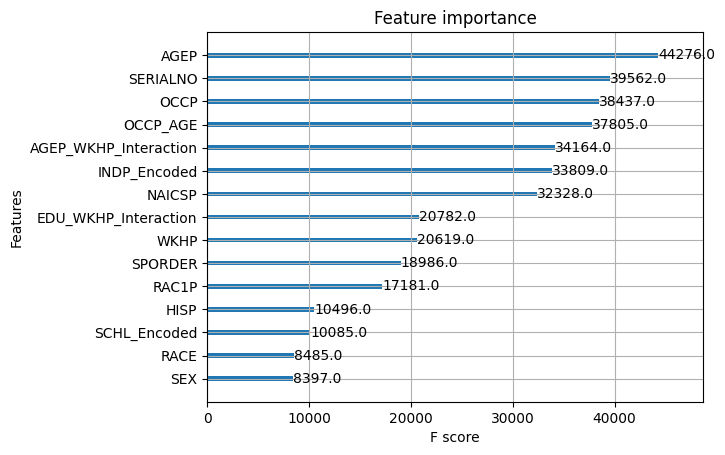

In [20]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_model, importance_type='weight', max_num_features=15)  # Shows top 15 features
plt.show()


# XGB Modelling

In [31]:
##BEST
#%%time
# Copy dataset
dfStack = df_clean.copy()
# Define target variable
y = dfStack['WAGP_Log'] 
# Drop unnecessary columns
X = dfStack.drop(columns=['WAGP', 'SCIENGRLP', 'SCHL', 'INDP', 'WAGP_Log'])
# Feature Engineering
#X['AGEP_WKHP_Interaction'] = X['AGEP'] * X['WKHP']
#X['EDU_WKHP_Interaction'] = X['SCHL_Encoded'] * X['WKHP']
X['OCCP_AGE'] = X['AGEP'] * X['OCCP']
X['AGE_NAICSP'] = X['AGEP'] * X['NAICSP']
#X['OCCP_SERIALNO'] = X['SERIALNO'] * X['OCCP']
# Standardize numerical features
num_features = ['AGEP', 'WKHP', 'INDP_Encoded']
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
#=======================
# Define models
xgb_model = XGBRegressor(
    n_estimators=300, 
    learning_rate=0.05,
    max_depth=12, 
    min_child_weight=2,
    colsample_bytree=0.75,
    subsample=0.9,
    #reg_alpha=0.1,
    #reg_lambda=0.1,
    random_state=5555
)
# Train both models
%time xgb_model.fit(X_train, y_train)
# Get predictions
%time y_pred_xgb = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGB Model R-squared Score: {r2_xgb:.4f}")




CPU times: total: 43.1 s
Wall time: 17.8 s
CPU times: total: 2.31 s
Wall time: 1.01 s
XGB Model R-squared Score: 0.6370


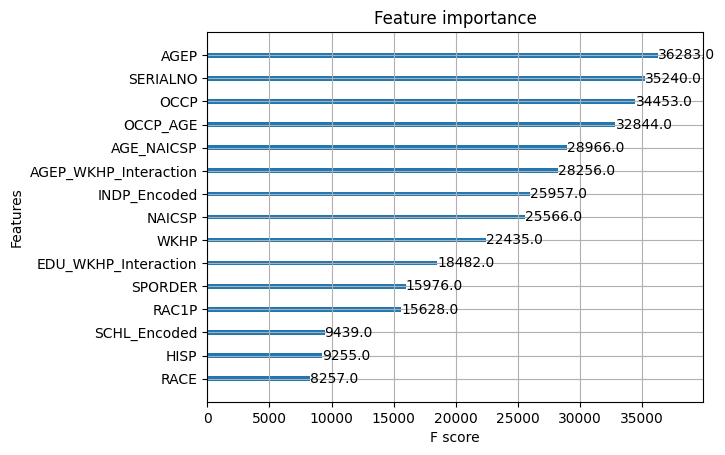

In [26]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_model, importance_type='weight', max_num_features=15)  # Shows top 15 features
plt.show()


In [32]:
##BEST
#%%time
# Copy dataset
dfStack = df_clean.copy()
# Define target variable
y = dfStack['WAGP_Log'] 
# Drop unnecessary columns
X = dfStack.drop(columns=['WAGP', 'SCIENGRLP', 'SCHL', 'INDP', 'WAGP_Log'])
# Feature Engineering
#X['AGEP_WKHP_Interaction'] = X['AGEP'] * X['WKHP']
#X['EDU_WKHP_Interaction'] = X['SCHL_Encoded'] * X['WKHP']
X['OCCP_AGE'] = X['AGEP'] * X['OCCP']
X['AGE_NAICSP'] = X['AGEP'] * X['NAICSP']
X['OCCP_SERIALNO'] = X['SERIALNO'] * X['OCCP']
# Standardize numerical features
num_features = ['AGEP', 'WKHP', 'INDP_Encoded']
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
#=======================
# Define models
xgb_model = XGBRegressor(
    n_estimators=300, 
    learning_rate=0.05,
    max_depth=12, 
    min_child_weight=2,
    colsample_bytree=0.75,
    subsample=0.9,
    #reg_alpha=0.1,
    #reg_lambda=0.1,
    random_state=5555
)
# Train both models
%time xgb_model.fit(X_train, y_train)
# Get predictions
%time y_pred_xgb = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGB Model R-squared Score: {r2_xgb:.4f}")




CPU times: total: 46.5 s
Wall time: 20.1 s
CPU times: total: 2.36 s
Wall time: 953 ms
XGB Model R-squared Score: 0.6354


In [41]:
##BEST
#%%time
# Copy dataset
dfStack = df_clean.copy()
# Define target variable
y = dfStack['WAGP_Log'] 
# Drop unnecessary columns
X = dfStack.drop(columns=['WAGP', 'SCIENGRLP', 'SCHL', 'INDP', 'WAGP_Log'])
# Feature Engineering
#X['AGEP_WKHP_Interaction'] = X['AGEP'] * X['WKHP']
#X['EDU_WKHP_Interaction'] = X['SCHL_Encoded'] * X['WKHP']
X['OCCP_AGE'] = X['AGEP'] * X['OCCP']
X['AGE_NAICSP'] = X['AGEP'] * X['NAICSP']
X['OCCP_SERIALNO'] = X['SERIALNO'] * X['OCCP']
# Standardize numerical features
num_features = ['AGEP', 'WKHP', 'INDP_Encoded']
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
#=======================
# Define models
xgb_model = XGBRegressor(
    n_estimators=500, 
    learning_rate=0.03,
    max_depth=12, 
    min_child_weight=2,
    colsample_bytree=0.75,
    subsample=0.9,
    #reg_alpha=0.1,
    #reg_lambda=0.1,
    random_state=5555
)
# Train both models
%time xgb_model.fit(X_train, y_train)
# Get predictions
%time y_pred_xgb = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGB Model R-squared Score: {r2_xgb:.4f}")




CPU times: total: 1min 34s
Wall time: 38.5 s
CPU times: total: 4.48 s
Wall time: 2.07 s
XGB Model R-squared Score: 0.6375


In [49]:
##BEST
#%%time
# Copy dataset
dfStack = df_clean.copy()
# Define target variable
y = dfStack['WAGP_Log'] 
# Drop unnecessary columns
X = dfStack.drop(columns=['WAGP', 'SCIENGRLP', 'SCHL', 'INDP', 'WAGP_Log'])
# Feature Engineering
#X['AGEP_WKHP_Interaction'] = X['AGEP'] * X['WKHP']
#X['EDU_WKHP_Interaction'] = X['SCHL_Encoded'] * X['WKHP']
X['OCCP_AGE'] = X['AGEP'] * X['OCCP']
X['AGE_NAICSP'] = X['AGEP'] * X['NAICSP']
X['OCCP_SERIALNO'] = X['SERIALNO'] * X['OCCP']
# Standardize numerical features
num_features = ['AGEP', 'WKHP', 'INDP_Encoded']
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
#=======================
# Define models
xgb_model = XGBRegressor(
    n_estimators=550, 
    learning_rate=0.035,
    max_depth=12, 
    min_child_weight=2,
    colsample_bytree=0.75,
    subsample=0.9,
    #reg_alpha=0.1,
    #reg_lambda=0.1,
    random_state=5555
)
# Train both models
%time xgb_model.fit(X_train, y_train)
# Get predictions
%time y_pred_xgb = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGB Model R-squared Score: {r2_xgb:.4f}")




CPU times: total: 1min 40s
Wall time: 31.3 s
CPU times: total: 4.41 s
Wall time: 1.5 s
XGB Model R-squared Score: 0.6380


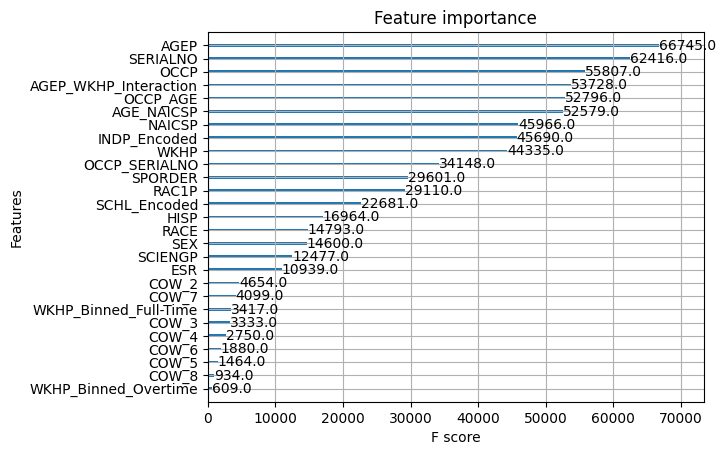

In [56]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_model, importance_type='weight', max_num_features=28)  # Shows top 15 features
plt.show()


In [62]:


# Copy dataset
dfStack = df_clean.copy()

# Define target variable
y = dfStack['WAGP_Log'] 

# Drop unnecessary columns
X = dfStack.drop(columns=['WAGP', 'SCIENGRLP', 'SCHL', 'INDP', 'WAGP_Log'])

# Feature Engineering
X['OCCP_AGE'] = X['AGEP'] * X['OCCP']
X['AGE_NAICSP'] = X['AGEP'] * X['NAICSP']
X['OCCP_SERIALNO'] = X['SERIALNO'] * X['OCCP']

# Standardize numerical features
num_features = ['AGEP', 'WKHP', 'INDP_Encoded']
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# =======================
# **Lasso Regularization for Feature Selection**
lasso = Lasso(alpha=0.001)  # Adjust alpha based on performance
lasso.fit(X_train, y_train)

# Select only non-zero coefficient features
selected_features = X_train.columns[lasso.coef_ != 0]
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# =======================
# Define optimized XGBoost model
xgb_model = XGBRegressor(
    n_estimators=550, 
    learning_rate=0.035,
    max_depth=12, 
    min_child_weight=2,
    colsample_bytree=0.75,
    subsample=0.9,
    random_state=5555
)

# Train the model
xgb_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGB Model with Lasso Feature Selection - R-squared Score: {r2_xgb:.4f}")


C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.710e+04, tolerance: 1.955e+01
  model = cd_fast.enet_coordinate_descent(


XGB Model with Lasso Feature Selection - R-squared Score: 0.6347


In [ ]:
# Define updated XGBoost model with built-in regularization
xgb_model = XGBRegressor(
    n_estimators=550, 
    learning_rate=0.035,
    max_depth=12, 
    min_child_weight=2,
    colsample_bytree=0.75,
    subsample=0.9,
    reg_alpha=0.5,        
    reg_lambda=1.0,       
    random_state=5555
)

# Train and evaluate
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGB Model with Built-in Regularization - R-squared Score: {r2_xgb:.4f}")


XGB Model with Built-in Regularization - R-squared Score: 0.6346


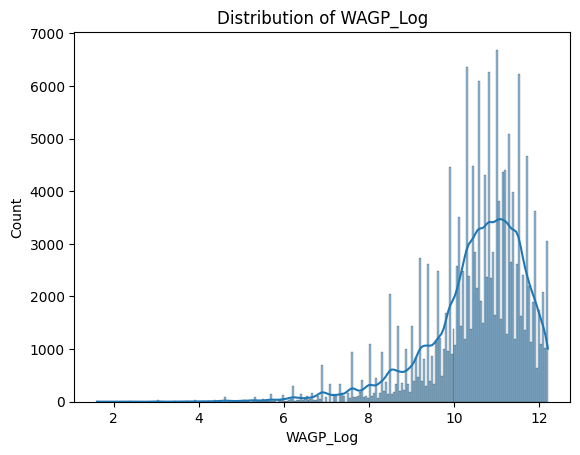

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df_clean['WAGP_Log'], kde=True)
plt.title('Distribution of WAGP_Log')
plt.show()


In [74]:
# Model on untransformed WAGP
y_original = df_clean['WAGP']
X_train, X_test, y_train, y_test = train_test_split(X, y_original, test_size=0.2, random_state=1234)

xgb_model.fit(X_train, y_train)
y_pred_original = xgb_model.predict(X_test)

r2_original = r2_score(y_test, y_pred_original)
print(f"XGB Model on WAGP (Untransformed) - R²: {r2_original:.4f}")


XGB Model on WAGP (Untransformed) - R²: 0.5976


In [ ]:
from scipy.stats import boxcox

y_transformed, lambda_bc = boxcox(y + 1)  
print(f"Optimal Box-Cox Lambda: {lambda_bc}")


Optimal Box-Cox Lambda: 4.9525262762789275


In [76]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
y_transformed = pt.fit_transform(y.values.reshape(-1, 1))


# Try Neural Net

In [77]:


# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test Mean Absolute Error: {mae:.2f}")

y_pred = model.predict(X_test_scaled)

# Compute R² score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")


C:\Users\rohan\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\data_adapter.py:1798: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/100
3556/3556 [==============================] - 24s 5ms/step - loss: 2554939136.0000 - mae: 36427.9492 - val_loss: 1270186880.0000 - val_mae: 25349.4160
Epoch 2/100
3556/3556 [==============================] - 13s 4ms/step - loss: 1203800832.0000 - mae: 24680.1426 - val_loss: 1160813696.0000 - val_mae: 24268.6426
Epoch 3/100
3556/3556 [==============================] - 14s 4ms/step - loss: 1153436160.0000 - mae: 24228.5977 - val_loss: 1135900160.0000 - val_mae: 24013.3047
Epoch 4/100
3556/3556 [==============================] - 14s 4ms/step - loss: 1136043904.0000 - mae: 24084.2344 - val_loss: 1125562112.0000 - val_mae: 24021.0664
Epoch 5/100
3556/3556 [==============================] - 14s 4ms/step - loss: 1127389440.0000 - mae: 24012.2500 - val_loss: 1119254016.0000 - val_mae: 23925.6992
Epoch 6/100
3556/3556 [==============================] - 13s 4ms/step - loss: 1122838400.0000 - mae: 23973.6152 - val_loss: 1116697600.0000 - val_mae: 23849.9375
Epoch 7/100
3556/3556 [=====